# Hovmoller Temperature Depth

This notebook shows how to calculate a depth-time Hovmoller plot of 30-year anomalies of globally averaged of conservative temperature, practical salinity from ACCESS-OM2 between Jan 1989 and Dec 2018.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cosima_cookbook as cc
from matplotlib.gridspec import GridSpec
import cmocean.cm as cm
import xarray as xr
from dask.distributed import Client
import IPython.display
import matplotlib.dates as mdates
from matplotlib import ticker

In [49]:
client = Client(n_workers = 4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33181/status,
Dashboard: /proxy/33181/status,Workers: 4
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40277,Workers: 4
Dashboard: /proxy/33181/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:34915,Total threads: 7
Dashboard: /proxy/35939/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:44059,


In [50]:
## Opening the cosima cookbook session
session = cc.database.create_session()
expt1deg = '1deg_jra55_iaf_omip2_cycle6'  # 1-deg experiment
start_time, end_time = '1989-01-01', '2018-12-31'

In [51]:
def load_var(experiment, var, freq, start_time, end_time):
    var_load = cc.querying.getvar(experiment, var, session, frequency = freq, 
                                  start_time=start_time, end_time=end_time)
    var_load.sel(time=slice(start_time, end_time))
    if var == 'temp':
        return var_load - 273.15
    else:
        return var_load
    

In [52]:
## Loading the variables
temp_1deg = load_var(expt1deg, 'temp', '1 monthly', start_time, end_time)
salt_1deg = load_var(expt1deg, 'salt', '1 monthly', start_time, end_time)
IPython.display.clear_output()

In [53]:
temp_anomaly_1deg = temp_1deg - temp_1deg.mean('time') # Computing the anomaly relative to the 30year time average
salt_anomaly_1deg = salt_1deg - salt_1deg.mean('time') # Computing the anomaly relative to the 30year time average

Next, we load cell area (denoted $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$


In [55]:
## Loading the dxt and dyt to estimate the area
dxt_1deg = cc.querying.getvar(expt1deg, 'dxt', session, frequency='static', n = 1)
dyt_1deg = cc.querying.getvar(expt1deg, 'dyt', session, frequency='static', n = 1)
area_1deg = dxt_1deg*dyt_1deg

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \tilde{\theta}(x,y,z,t)}{A(z)}$$
where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [56]:
### Temperature hovmoller
temp_hov_1deg = ((area_1deg*temp_anomaly_1deg).sum('xt_ocean').sum('yt_ocean'))/area_1deg.sum('xt_ocean').sum('yt_ocean')
temp_hov_1deg = temp_hov_1deg.compute()

### Salinity hovmoller
salt_hov_1deg = ((area_1deg*salt_anomaly_1deg).sum('xt_ocean').sum('yt_ocean'))/area_1deg.sum('xt_ocean').sum('yt_ocean')
salt_hov_1deg = salt_hov_1deg.compute()

IPython.display.clear_output()

In [57]:
myFmt = mdates.DateFormatter('%Y')
def plot_hov(fsize = 14, date_format = myFmt):
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = fsize
    plt.rcParams['ytick.labelsize'] = fsize
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    
    fig = plt.figure(figsize = (10,6))
    grd = GridSpec(100,100)
    
    ax = [fig.add_subplot(grd[:30,:30]), fig.add_subplot(grd[:30,33:63]),
          fig.add_subplot(grd[32:,:30]), fig.add_subplot(grd[32:,33:63])]
    for i in range(len(ax)):
        ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 
    
    return fig, ax

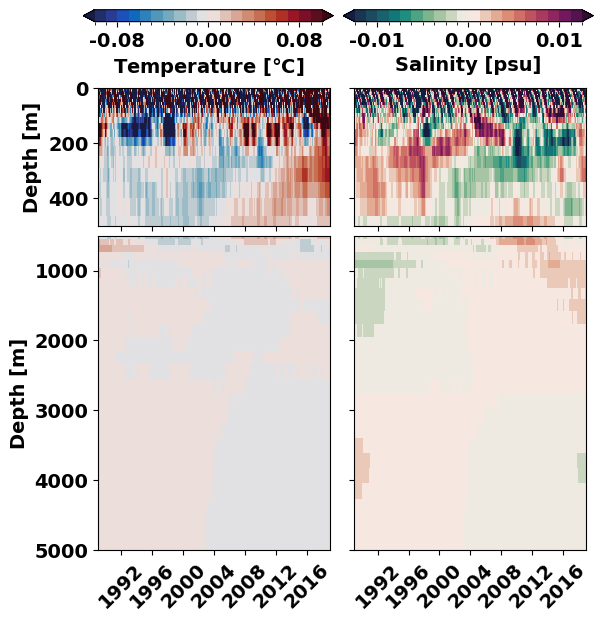

In [58]:
fig, ax = plot_hov(fsize = 14)
lv_temp = np.arange(-.1,.11,.01)
lv_salt = np.arange(-.01,.011,.001)

cf_temp = temp_hov_1deg.plot(ax = ax[0], levels = lv_temp, x = 'time',  y = 'st_ocean', add_colorbar = False, label = None, cmap = cm.balance, extend = 'both')
temp_hov_1deg.plot(ax = ax[2], levels = lv_temp, x = 'time',  y = 'st_ocean', add_colorbar = False, label = None, cmap = cm.balance, extend = 'both')

cf_salt = salt_hov_1deg.plot(ax = ax[1], levels = lv_salt, x = 'time',  y = 'st_ocean', add_colorbar = False, label = None, cmap = cm.curl, extend = 'both')
salt_hov_1deg.plot(ax = ax[3], levels = lv_salt, x = 'time',  y = 'st_ocean', add_colorbar = False, label = None, cmap = cm.curl, extend = 'both')

## Details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(500,0)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel('')
        ax[i].set_ylim(5000,500)
ax[0].set_ylabel("Depth [m]")
ax[2].set_ylabel("Depth [m]")
ax[1].set_ylabel('')
ax[3].set_ylabel('')

# Colorbar
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_1.set_label('Temperature [$\degree$C]')

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_2.set_label('Salinity [psu]')

cbar = [cbar_1, cbar_2]
for i in range(len(cbar)):
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar[i].locator = tick_locator
    cbar[i].update_ticks()